In [40]:
import torch
import numpy as np
import torchvision.models as models
import ImportanceScores as ISDataloader
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
import csv
import datetime
import random

k = 4
size = 5000
tSize = 12

ISLoader = ISDataloader.main('vidData/videoDataGA.csv', 'tensorsGA/', size) #for train dataloader
testLoader = ISDataloader.main('vidData/videoDataFull.csv', 'tensors/', tSize) #for test dataloader

def accuracy(x,y):
    xy = 1 - (np.sum(abs(np.subtract(x,y)) > 0.05)/len(x))
    if xy <= 0:
        xy = 0
    return xy



~~~| ImportanceScore.py Execution |~~~
Loaded dataset
~~~| ImportanceScore.py Complete |~~~


~~~| ImportanceScore.py Execution |~~~
Loaded dataset
~~~| ImportanceScore.py Complete |~~~



In [41]:
"""
Reading in data to get single batch for training
"""
print("~~ Training Data ~~")
batchData = []
for batch_i, data in enumerate(ISLoader): 
    print("batch: ", batch_i)
    batchData.append(data)
    if batch_i == 11:
        break
        
print(batchData[0]['video'].shape)
flatten = batchData[0]['video'].view((4,k,-1))
print(flatten.shape)
print(batchData[0]['score'][0])
    
print("~~ Testing Data ~~")
testData = []
for batch_i, data in enumerate(testLoader): 
    print("batch: ", batch_i)
    for i in range(len(data['video'])):
        testData = data
        print(testData['video'].shape)
        flatten = testData['video'].view((4,k,-1))
        print(flatten.shape)
        print(testData['score'][i])
    break


~~ Training Data ~~
batch:  0
batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6
batch:  7
batch:  8
batch:  9
batch:  10
batch:  11
torch.Size([4, 4, 512, 7, 7])
torch.Size([4, 4, 25088])
tensor(0.3300)
~~ Testing Data ~~
batch:  0
torch.Size([4, 4, 512, 7, 7])
torch.Size([4, 4, 25088])
tensor(0.5800)
torch.Size([4, 4, 512, 7, 7])
torch.Size([4, 4, 25088])
tensor(0.5800)
torch.Size([4, 4, 512, 7, 7])
torch.Size([4, 4, 25088])
tensor(0.3400)
torch.Size([4, 4, 512, 7, 7])
torch.Size([4, 4, 25088])
tensor(0.3400)


In [47]:
"""
USING Sigmoid
"""

import torch.nn as nn
from torch.nn.parameter import Parameter
class MyModel(nn.Module):
    def __init__(self, inputDim, outputDim, k):
        super(MyModel, self).__init__()
        self.lstm = torch.nn.LSTM(inputDim, outputDim, 1, True, True, 0.5);
        self.fc = nn.Linear(outputDim, 1)
        self.flatten_parameters()
        self.sigmoid = nn.Sigmoid()
        self.inputDim = inputDim
        self.k = k
    
    def flatten_parameters(self):
        self.lstm.flatten_parameters()
        
    def forward(self, x):
        #x = 4 x k x (512 x 7 x 7) <- Needs to be flattened

        #4 x k x 25088
        xFlat = x.view((4,self.k,-1))

        #Output from LSTM 4 x 3 x 256
        lstmOut, _ = self.lstm(xFlat)
        #print(lstmOut.shape)
        lastOut = lstmOut[-1]
        
        sigOut = self.sigmoid(self.fc(lastOut))
        return sigOut

~~ Training ~~
[0.10533066093921661, 0.08227843046188354, 0.1222766637802124, 0.007603835314512253, 0.11767767369747162, 0.16203734278678894, 0.062345001846551895, 0.08544112741947174, 0.11140449345111847, 0.09252317994832993, 0.07743917405605316, 0.05546114221215248]
Accuracy: 0.25


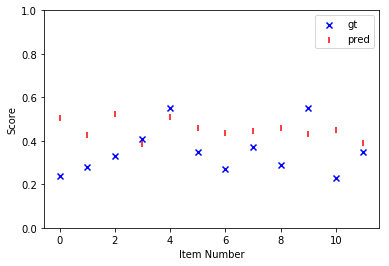

[4.436540621099994e-06, 3.425532122491859e-05, 1.4499951248581056e-05, 0.0008226978243328631, 0.000276899547316134, 6.260221562115476e-05, 0.0005962229333817959, 0.01992831937968731, 0.00016218237578868866, 0.0804000049829483, 0.0017560066189616919, 0.0003629476414062083]
Accuracy: 0.9166666666666666


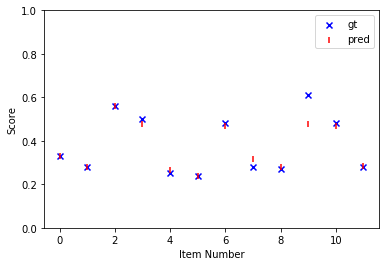

Number of Enumerations:  1200
~~ Testing ~~
[0.58 0.58 0.34 0.34 0.58 0.58 0.34 0.34]
[0.5227496  0.4081673  0.45758194 0.47002134 0.5227496  0.4081673
 0.45758194 0.47002134]
Accuracy: 0.0


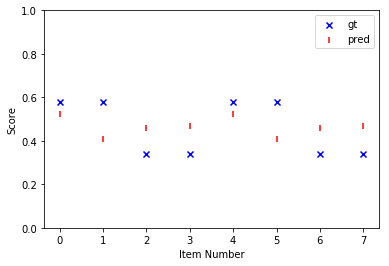

In [48]:
"""
Using Cuda

"""

model = MyModel(512*7*7, 256, k).cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss(reduction='sum').cuda()
with open('results/twelveItem.tsv', "w+") as tsv_file:
    writer = csv.writer(tsv_file, delimiter='\t')
    time = datetime.datetime.now()
    writer.writerow([str(time)])
    writer.writerow(["~~ Training Error ~~"])
    enums = 0
    num_epochs = 100
    print("~~ Training ~~")
    for epoch in range(num_epochs):
        errors = []
        gtx = []
        gty = []
        genx = []
        geny = []
        for i in range(len(batchData)):
            x = Variable(torch.tensor(batchData[i]['video'], dtype=torch.float32)).cuda()
            y = Variable(torch.tensor(batchData[i]['score'], dtype=torch.float32)).cuda()
            optimizer.zero_grad()
            out = model(x)
            loss_fn = torch.nn.MSELoss(reduction='sum').cuda()
            error = loss_fn(out.flatten(), y).cuda()
            if epoch % 50 == 0:
                index = random.randint(0,3)
                errors.append(error.item())
                gty.append(y[index].detach().cpu().item())
                geny.append(out[index].detach().cpu().item())
                gtx.append(i)
                genx.append(i)
            enums += 1
            error.backward()     
            optimizer.step() 
        if epoch % 50 == 0:
            print(errors)
            writer.writerow(["Epoch: " + str(epoch) + " Average Accuracy: "+  str(accuracy(gty, geny))])
            print("Accuracy: " + str(accuracy(gty, geny)))
            ax = plt.subplot(111)
            plt.scatter(gtx, gty, c='b', marker='x', label='gt')
            plt.scatter(genx, geny, c='r', marker='|', label='pred')
            ax.legend(loc='best')
            plt.xlabel("Item Number")
            plt.ylabel("Score")
            plt.ylim(0.0,1.0)
            plt.savefig("Images/TwelveBatch-epoch-"+str(epoch)+".jpg")
            #plt.savefig("Images/"+str(size)+"-test.jpg")
            #plt.savefig("Images/TwelveBatch-test.jpg")
            plt.show()


    print("Number of Enumerations: ", enums)
    print("~~ Testing ~~")
    geny = []
    gty = []
    for i in range(len(testData)):
        x = Variable(torch.tensor(testData['video'], dtype=torch.float32)).cuda()
        y = Variable(torch.tensor(testData['score'], dtype=torch.float32)).cuda()
        optimizer.zero_grad()
        out = model(x)
        loss_fn = torch.nn.MSELoss(reduction='sum').cuda()
        error = loss_fn(out.flatten(), y).cuda()
        #print("Actual: ", y.cpu().numpy())
        #print("Generated: ",out.detach().flatten().cpu().numpy())
        gty.append(y.cpu().numpy())
        geny.append(out.detach().flatten().cpu().numpy())
    ax = plt.subplot(111)
    gty = np.array(gty).flatten()
    geny = np.array(geny).flatten()
    print(gty)
    print(geny) 
    print("Accuracy: " + str(accuracy(gty, geny)))
    time = datetime.datetime.now()
    writer.writerow([str(time)])
    writer.writerow(["~~ Testing ~~"]) 
    writer.writerow(["Ground Truth: " + str(gty)])
    writer.writerow(["Generated: " + str(geny)])
    writer.writerow(["Average Accuracy: " +  str(accuracy(gty, geny))])
    plt.scatter(range(len(gty)), gty, c='b', marker='x', label='gt')
    plt.scatter(range(len(geny)), geny, c='r', marker='|', label='pred')
    ax.legend(loc='best')
    plt.xlabel("Item Number")
    plt.ylabel("Score")
    plt.ylim(0.0,1.0)
    #plt.savefig("Images/"+str(size)+"-test.jpg")
    plt.savefig("Images/TwelveBatch-test.jpg")
    plt.show()

